In [1]:
import os
from skimage import measure
from PIL import Image
import numpy as np
from skimage.segmentation import active_contour
import matplotlib.pyplot as plt
from skimage.transform import resize
import cv2

In [2]:
def point_to_line_dist(point, line):
    """Calculate the distance between a point and a line segment.

    To calculate the closest distance to a line segment, we first need to check
    if the point projects onto the line segment.  If it does, then we calculate
    the orthogonal distance from the point to the line.
    If the point does not project to the line segment, we calculate the 
    distance to both endpoints and take the shortest distance.

    :param point: Numpy array of form [x,y], describing the point.
    :type point: numpy.core.multiarray.ndarray
    :param line: list of endpoint arrays of form [P1, P2]
    :type line: list of numpy.core.multiarray.ndarray
    :return: The minimum distance to a point and bool if point lie on line.
    :rtype: (float, bool)
    """
    # unit vector
    unit_line = line[1] - line[0]
    norm_unit_line = unit_line / np.linalg.norm(unit_line)
    # compute the perpendicular distance to the theoretical infinite line
    segment_dist = (
        np.linalg.norm(np.cross(line[1] - line[0], line[0] - point)) /
        np.linalg.norm(unit_line)
    )

    diff = (
        (norm_unit_line[0] * (point[0] - line[0][0])) + 
        (norm_unit_line[1] * (point[1] - line[0][1]))
    )

    x_seg = (norm_unit_line[0] * diff) + line[0][0]
    y_seg = (norm_unit_line[1] * diff) + line[0][1]

    endpoint_dist = min(
        np.linalg.norm(line[0] - point),
        np.linalg.norm(line[1] - point)
    )

    # decide if the intersection point falls on the line segment
    lp1_x = line[0][0]  # line point 1 x
    lp1_y = line[0][1]  # line point 1 y
    lp2_x = line[1][0]  # line point 2 x
    lp2_y = line[1][1]  # line point 2 y
    is_betw_x = lp1_x <= x_seg <= lp2_x or lp2_x <= x_seg <= lp1_x
    is_betw_y = lp1_y <= y_seg <= lp2_y or lp2_y <= y_seg <= lp1_y
    if is_betw_x and is_betw_y:
        return segment_dist

    else:
        # if not, then return the minimum distance to the segment endpoints
        return endpoint_dist


In [3]:
import numpy as np


In [4]:
#%load_ext Cython
%reload_ext Cython




In [5]:

%%cython -a
cimport cython
cimport numpy as np

#ctypedef np.ndarray[np.float_t, ndim=1] TUPLE_T

@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
cdef float norm(np.ndarray[np.float_t, ndim=1] point):
    return (point[0]**2+point[1]**2)**0.5

@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
cdef float cross(np.ndarray[np.float_t, ndim=1] a, np.ndarray[np.float_t, ndim=1] b):
    return a[0]*b[1]-a[1]*b[0]

cdef float dist(double* a, double *b) nogil:
    return (a[0]-b[0])*(a[0]-b[0])+(a[1]-b[1])*(a[1]-b[1])

cdef float c_point_line_dist(double* p, double* l1, double* l2)  nogil:
    cdef float s = dist(l1,l2)
    if(s == 0):
        return dist(p,l1)
    v = l1
    cdef float t = ((p[0] - l1[0]) * (l2[0] - l1[0]) + (p[1] - l1[1]) * (l2[1] - l1[1])) / s;
    t = max(0, min(1, t))
    cdef float x = l1[0]+t*(l2[0]-l1[0])
    cdef float y = l1[1]+t*(l2[1]-l1[1])
    return (p[0]-x)*(p[0]-x)+(p[1]-y)*(p[1]-y)

#   const vec2 projection = v + t * (w - v);  // Projection falls on the segment
#   return distance(p, projection);
# }
@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
cpdef point_to_line_dist_cython(double[:] point,double[:,:] line):
    """Calculate the distance between a point and a line segment.

    To calculate the closest distance to a line segment, we first need to check
    if the point projects onto the line segment.  If it does, then we calculate
    the orthogonal distance from the point to the line.
    If the point does not project to the line segment, we calculate the 
    distance to both endpoints and take the shortest distance.

    :param point: Numpy array of form [x,y], describing the point.
    :type point: numpy.core.multiarray.ndarray
    :param line: list of endpoint arrays of form [P1, P2]
    :type line: list of numpy.core.multiarray.ndarray
    :return: The minimum distance to a point and bool if point lie on line.
    :rtype: (float, bool)
    """
    cdef double* p = &point[0]
    cdef double* l1 = &line[0][0]
    cdef double* l2 = &line[1][0]
    
    return c_point_line_dist(p, l1, l2)
    
@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)
def get_distance_cython(double[:,:] points_a, double[:,:] points_b, float threshold):
    cdef float res = 0
    cdef int i,j
    cdef float current_dis = 1000000
        
    for i in range(len(points_a)):
        current_dis = 1000000
       
        for j in range(len(points_b)-1):
            j_next = (j+1)%len(points_b)
            current_dis = min(current_dis, point_to_line_dist_cython(points_a[i], points_b[j:j+2]))
        
        res = res + current_dis
        if res > threshold:
            return res
    return res

In [305]:
import skimage

def compute_angles(points):
    angles = []
    n = len(points)
    for poz in range(len(points)):
        a = points[poz-1]
        b = points[poz]
        c = points[(poz+1)%n]
        ab = a-b
        ac = c-b
        ab = ab/np.linalg.norm(ab)
        ac = ac/np.linalg.norm(ac)
        angles.append(np.dot(ab,ac)) #cos(a)
    return angles

def compute_exact_angles(points):
    angles = []
    n = len(points)
    for poz in range(1, n-1):
        a = points[poz-1]
        b = points[poz]
        c = points[(poz+1)%n]
        ab = np.sqrt(np.sum((a - b) ** 2))
        ac = np.sqrt(np.sum((a - c) ** 2))
        bc = np.sqrt(np.sum((b - c) ** 2))
        angle = np.arccos((ab ** 2 + bc ** 2 - ac **2 ) / (2 * ab * bc))
        angles.append(angle)
    return np.array(angles)

def next_point_good_side(points_idx, points):
    for i in range(len(points_idx)-1):
        b = points[points_idx[i+1]]
        c = points[points_idx[i]]
        poz = points_idx[0]+1
        poz %= len(points)
        bad_count = 0
        while poz != points_idx[1]:
            a = points[poz]
            poz = (poz+1)%len(points)
            if np.cross((a-b),(c-b)) < 0:
                bad_count += 1
        if bad_count > 1: #random close point
            return False
    return True

def get_lenght(points_idx, points):
    res = 0
    for a,b in zip(points_idx, points_idx[1:]):
        res += np.linalg.norm(points[a]-points[b])
    return res

def find_base_points_idx(contour):
    angles = compute_angles(contour)
    eps = 0.00
    options = []
    while eps < 1.1 and len(options) == 0:
        for p in range(len(contour)):
            if (np.abs(angles[p]) < eps and np.abs(angles[p-1]) < eps): #and 
                #np.linalg.norm(contour[p]-contour[p-1]) > 10):
                
                options.append([(p+1)%len(contour), p,
                               (p-1)%len(contour), (p-2)%len(contour)])
        options = [_ for _ in options if next_point_good_side(_, contour)]
        eps += 0.05
    if len(options) > 0:
        res = options[0]
        res_lenght = get_lenght(res, contour)
        for o in options[1:]:
            lenght = get_lenght(o, contour)
            if lenght > res_lenght:
                res_lenght = lenght
                res = o
        return res
    return [0,1,2,3] # Broken
                
def generate_top_and_base_points(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    _,canimg = cv2.threshold(gray, 127,255, cv2.THRESH_BINARY)
    contours,_ = cv2.findContours(canimg, cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_SIMPLE)
    
    contour = contours[0]
    for c in contours:
        if c.shape[0] > contour.shape[0]:
            contour = c
    contour = cv2.approxPolyDP(contour, 10, True)
    contour = contour.reshape((-1,2))
    
    
    base = find_base_points_idx(contour)
    
#     plt.imshow(np.ones(gray.shape), cmap='gray')
#     plt.plot(contour[:,0], contour[:,1])
#     plt.plot([contour[i,0] for i in base[1:3]], [contour[i,1] for i in base[1:3]])
#     plt.show()
    
    n = len(contour)
    poz = base[0]
    top_points = []
    while poz != base[-2]:
        top_points.append(contour[poz])
        poz = (poz+1)%n
    top_points = np.array(top_points) 
    base_points = np.array([contour[i,:] for i in base])
    return top_points, base_points
def generate_data(path):
    images_paths = [os.path.join(path,x) for x in os.listdir(path) if ".png" in x]
    all_top_points = []
    all_base_points = []
    for p in sorted(images_paths, key=lambda x: int(x.split("/")[1].split(".")[0])): #TODO
        image = cv2.imread(p)
        image = cv2.resize(image, (1000,1000))
        top_points, base_points = generate_top_and_base_points(image)
        all_top_points.append(top_points)
        all_base_points.append(base_points)
#         plt.imshow(np.zeros(image.shape))
#         plt.plot(top_points[:,0], top_points[:,1])
#         plt.show()
    return all_top_points, all_base_points


def normalize_data(images_points):
    res = []
    base_vec = np.array([1,0])
    for i, points in enumerate(images_points):
#         if i == 1:
#             print("normalize:")
#             image = cv2.imread(f"set3/{i}.png")
#             image = cv2.resize(image, (1000,1000))
#             plt.imshow(image)
#             plt.show()
#             plt.imshow(np.zeros(image.shape))
#             plt.plot(points[:,0], points[:,1])
#             plt.show()
        points = points-points[0]
#         if i == 1:
#             print("minus [0]")
#             plt.imshow(np.zeros(image.shape))
#             plt.plot(points[:,0], points[:,1])
#             plt.show()
#             print(np.linalg.norm(points[-1]))
        points = points/np.linalg.norm(points[-1])
#         if i == 1:
#             print("div norm")
#             plt.plot(points[:,0], points[:,1]*-1)
#             plt.show()
        cos = np.dot(points[-1],base_vec)/np.linalg.norm(points[-1])
        sin = np.cross(points[-1],base_vec)/np.linalg.norm(points[-1])
        j = np.matrix([[cos, sin], [-sin, cos]])
        tmp = np.matmul(points, j)
        tmp[:,1] /= np.max(np.abs(tmp[:,1]))
        res.append(tmp)
#         if i == 1:
#             print("matmul")
#             plt.plot(tmp[:,0], tmp[:,1]*-1)
#             plt.show()
    
    return res


def normalize_2(images_points, images_bases):
    #TODO: first fix the perspective
    
    # assuming that perspective is OK...
    base_lengths = [] 
    # rotation
    res = []
    for edge_points, base_points in zip(images_points, images_bases):
        base_matrix = np.array([
            base_points[0] - base_points[1],
            base_points[2] - base_points[1]
        ])
        
        target_matrix = np.array([
            [0,np.linalg.norm(base_points[0] - base_points[1])],
            [np.linalg.norm(base_points[1] - base_points[2]), 0],
        ])
        rotation_matrix = np.linalg.inv(base_matrix) @ target_matrix
        res.append(edge_points @ rotation_matrix)
        
        base_lengths.append([
            np.linalg.norm(base_points[0] - base_points[1]), # left side
            np.linalg.norm(base_points[2] - base_points[1]), # base
            np.linalg.norm(base_points[3] - base_points[2]) # right side
        ])
    return res, np.array(base_lengths)


def get_distance(points_a, points_b, threshold):
    res = 0
    for p in points_a:
        distances_rev = [point_to_line_dist(np.array(p).flatten(), np.array([p1,p2]).reshape((2,2))) for p1,p2 in zip(points_b, points_b[1:])]
        res += np.min(distances_rev)
        if res > threshold:
            break
    return res

def generate_lukasz_ranking(other_points, points):
    res = []
    for other in other_points:
        rev_other = other.copy()*-1
        rev_other[:,0] += 1
        if len(res) > 0:
            threshold = sorted(res)[100%len(res)]
        else:
            threshold = 1000000
        res.append(get_distance_cython(points, rev_other, threshold)+get_distance_cython(rev_other, points, threshold))    
        #res.append(cv2.matchShapes(points, rev_other, cv2.CONTOURS_MATCH_I1,2))
      #  print(cv2.matchShapes(points, rev_other, cv2.CONTOURS_MATCH_I1,0))
        #res.append(get_distance(points, rev_other, threshold)+get_distance(rev_other, points, threshold))
        
  #  print(res)
    return np.array(res)


def generate_correlations_ranking(other_points, points):
    from scipy.interpolate import interp1d
    points=np.round(points,3)
    f = interp1d(points[:,0], points[:,1])
    res = []
    for other in other_points:
        rev_other = other.copy()*-1
        rev_other[:,0] += 1
        # normalize
        rev_other[:,0] = (rev_other[:,0] - min(rev_other[:,0])) / (max(rev_other[:,0]) - min(rev_other[:,0]))
        rev_other = np.round(rev_other,3)
        res.append(1-np.corrcoef(f(rev_other[:,0]),rev_other[:,1])[0][1])
    return np.array(res)

def generate_medians_ranking(other_points, points):
    from scipy.interpolate import interp1d
    points=np.round(points,3)
    f = interp1d(points[:,0], points[:,1])
    res = []
    for other in other_points:
        rev_other = other.copy()*-1
        rev_other[:,0] += 1
        # normalize
        rev_other[:,0] = (rev_other[:,0] - min(rev_other[:,0])) / (max(rev_other[:,0]) - min(rev_other[:,0]))
        
        rev_other = np.round(rev_other,3)
        res.append(np.median(np.abs(f(rev_other[:,0]) - rev_other[:,1])))
    return np.array(res)

def generate_means_ranking(other_points, points):
    from scipy.interpolate import interp1d
    points=np.round(points,3)
    f = interp1d(points[:,0], points[:,1])
    res = []
    for other in other_points:
        rev_other = other.copy()*-1
        rev_other[:,0] += 1
        # normalize
#         rev_other[:,0] = (rev_other[:,0] - min(rev_other[:,0])) / (max(rev_other[:,0]) - min(rev_other[:,0]))
        rev_other[:,0][rev_other[:,0] < 0] = 0
        rev_other[:,0][rev_other[:,0] > 1] = 1
        
        rev_other = np.round(rev_other,3)
        res.append(np.mean(np.abs(f(rev_other[:,0]) - rev_other[:,1])))
    return np.array(res)

def generate_angles_ranking(other_points, points):
    from scipy.interpolate import interp1d
    points=np.round(points,3)
    points_angles = compute_exact_angles(points)
    f = interp1d(points[:,0], points[:,1])
    res = []
    for other in other_points:
        rev_other = other.copy()*-1
        rev_other[:,0] += 1
        rev_other = np.round(rev_other,3)
        rev_angles = compute_exact_angles(rev_other)[::-1]
        
        # TODO: matching angles could be a lot better
        points_angles[::-1].sort()
        rev_angles[::-1].sort()
        
        min_len = min(points_angles.size, rev_angles.size)
        
        points_angles = points_angles[:min_len]
        rev_angles = rev_angles[:min_len]
        
        res.append(np.linalg.norm(points_angles - rev_angles))
    return np.array(res)

# ranking_methods = ['medians', 'correlations', 'lukasz', 'means', 'angles']
ranking_methods = ['lukasz']
weights = [1]
# weights=[0,0,1,0,0]
for path_set in [[f"set{i}" for i in range(0,5)], ["set5", "set6"], ["set7", "set8"]]:
# for path_set in [["set0"]]:
    set_score = 0
    for path in path_set:
        atp, abp = generate_data(path) # all top points, all base points
        t = normalize_data(atp)

        # t2, base_lengths = normalize_2(atp, abp)
        # plt.plot(t2[1][:,0], t2[1][:,1])
        # plt.show()
        correct = [int(line) for line in open(os.path.join(path, "correct.txt"))]
        score = 0
        p = 0
        rankings = {}
        for i, (current, correct) in enumerate(list(zip(t, correct))):
            rankings[i] = {}
            for rank_type in ranking_methods:
                rankings[i][rank_type] = eval(f"generate_{rank_type}_ranking(t, np.array(current))")
                rankings[i][rank_type][i] = 100

#         print(rankings[1])

        #normalize rankings
        for i in range(len(t)):
            for rank_type in ranking_methods:
                rankings[i][rank_type] = (rankings[i][rank_type] - min(rankings[i][rank_type])) / (max(rankings[i][rank_type]) - min(rankings[i][rank_type]))

#         print(rankings[0])

        # hstack rankings

        all_rankings = {}
        for i in range(len(t)):
            to_stack = [rankings[i][rank_type].reshape(len(t),1) for rank_type in ranking_methods]
            all_rankings[i] = np.hstack(to_stack)

        correct = [int(line) for line in open(os.path.join(path, "correct.txt"))]

        # aggregate rankings
        for i, (current, correct) in enumerate(list(zip(t, correct))):
            ranking = np.argsort(np.average(all_rankings[i], axis=1, weights=weights))
            score += 1/(np.where(ranking==correct)[0]+1)

        set_score += score/len(t)    
    print(set_score / len(path_set))



/home/dhorna/anaconda3/envs/put/lib/python3.6/site-packages/ipykernel_launcher.py:151: RuntimeWarning: invalid value encountered in true_divide


[0.91439776]
[0.93203571]
[0.84883624]


In [ ]:
#Random staff

In [14]:
a = np.random.rand(100,2)
b = np.random.rand(100,2)

%timeit point_to_line_dist(a[0],b[1:3])
%timeit point_to_line_dist_cython(a[0],b[1:3])

%timeit get_distance(a,b, 100000)
%timeit get_distance_cython(a,b, 100000)


49.2 µs ± 221 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
1.12 µs ± 68.8 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
650 ms ± 25.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
660 µs ± 28.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [130]:
# some tests

In [131]:
# 5 2 1 4 3 0

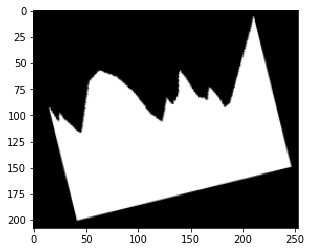

In [151]:
img = cv2.imread("set0/0.png")
plt.imshow(img)

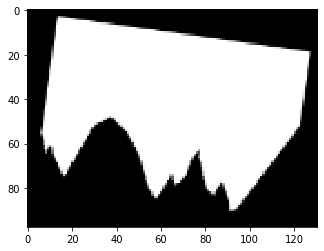

In [152]:
img = cv2.imread("set0/5.png")
plt.imshow(img)

In [153]:
atp, abp = generate_data("set0")

In [207]:
normalized = normalize_data(atp)

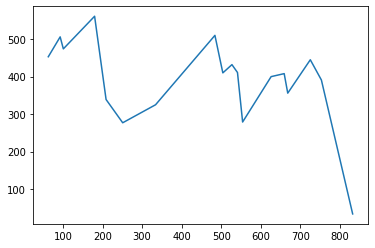

In [208]:
plt.plot(atp[0][:,0], atp[0][:,1])

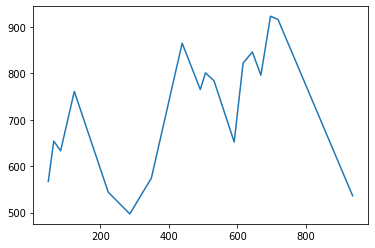

In [209]:
plt.plot(atp[5][:,0], atp[5][:,1])

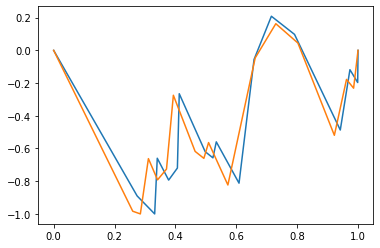

In [216]:
plt.plot(normalized[0][:,0], normalized[0][:,1])
rev = normalized[5] * -1
rev[:,0] += 1
plt.plot(rev[:,0], rev[:,1])

In [263]:
def compute_exact_angles(points):
    angles = []
    n = len(points)
    for poz in range(1, n-1):
        a = points[poz-1]
        b = points[poz]
        c = points[(poz+1)%n]
        ab = np.sqrt(np.sum((a - b) ** 2))
        ac = np.sqrt(np.sum((a - c) ** 2))
        bc = np.sqrt(np.sum((b - c) ** 2))
        angle = np.arccos((ab ** 2 + bc ** 2 - ac **2 ) / (2 * ab * bc))
        angles.append(angle)
    return np.array(angles)

In [264]:
norm_angles = compute_exact_angles(np.array(normalized[0]))

In [265]:
rev_angles = compute_exact_angles(np.array(rev))

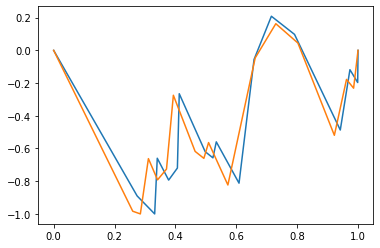

In [266]:
plt.plot(np.array(normalized[0])[:,0], np.array(normalized[0])[:,1])
plt.plot(np.array(np.array(rev))[:,0], np.array(np.array(rev))[:,1])

In [267]:
norm_angles

array([2.9576807 , 0.50783974, 0.29837881, 0.6450695 , 2.78324757,
       0.24934678, 2.78524486, 0.70460864, 0.39976777, 0.35259569,
       2.99433327, 0.81309812, 2.79263801, 0.33745919, 0.40034461,
       0.32035064])

In [269]:
rev_angles = rev_angles[::-1]

In [270]:
rev_angles

array([2.41151846, 1.06652321, 0.3057459 , 0.64726462, 2.771801  ,
       0.25520004, 2.75311014, 0.75250368, 0.39883144, 0.35506764,
       2.94326863, 0.86374809, 2.80032114, 0.32547752, 0.52609963,
       0.47271114])

In [271]:
norm_angles.shape

(16,)

In [272]:
rev_angles.shape

(16,)

In [283]:
np.mean(norm_angles - rev_angles)

-0.0191992729619206